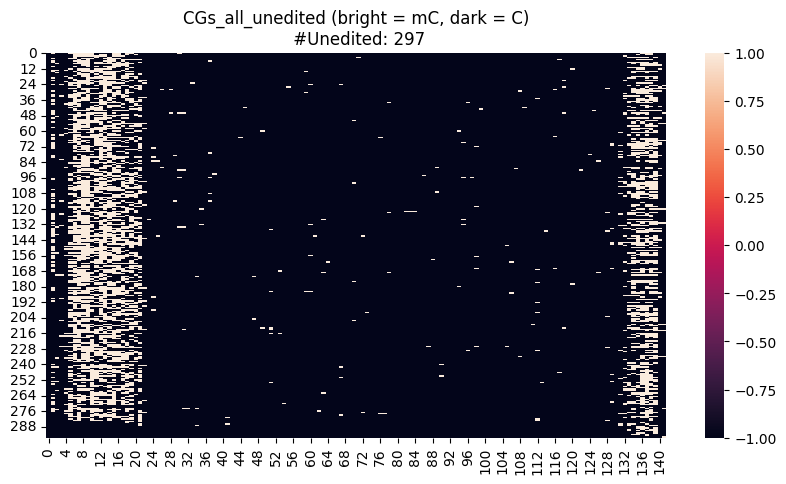

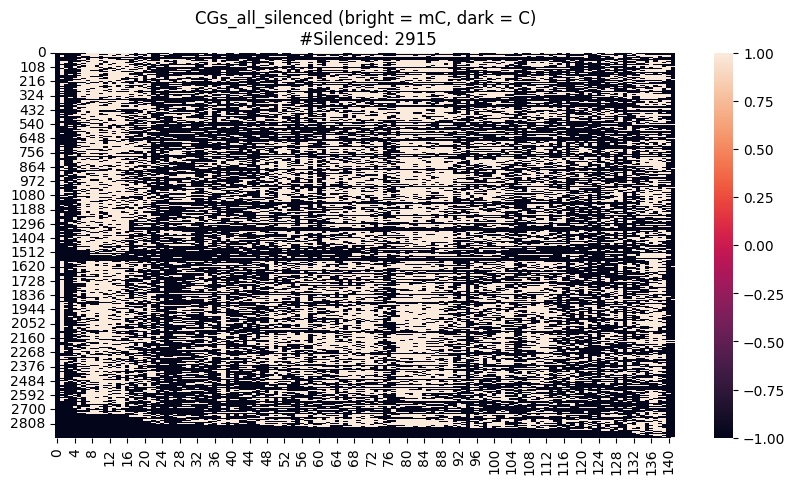

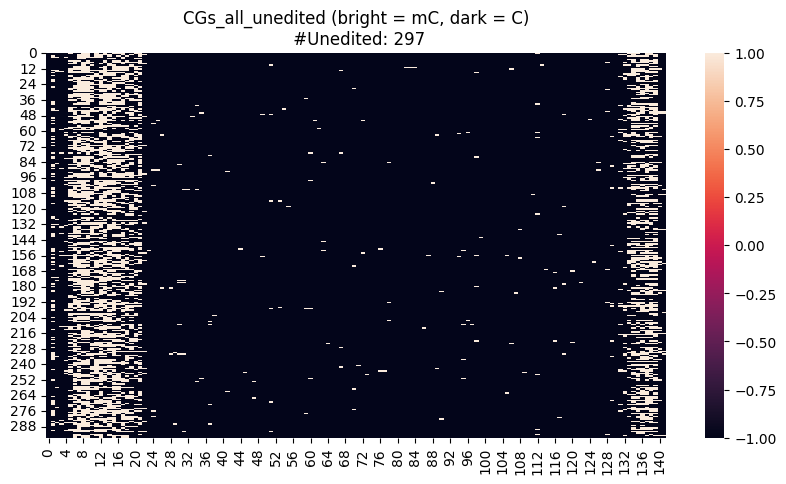

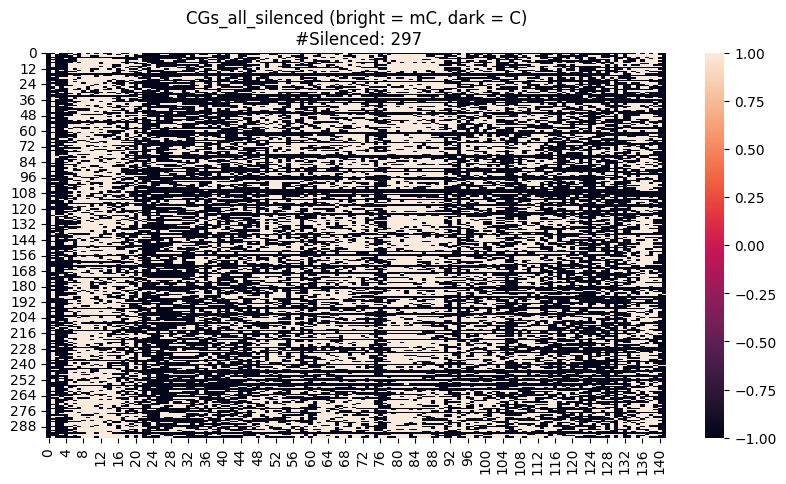

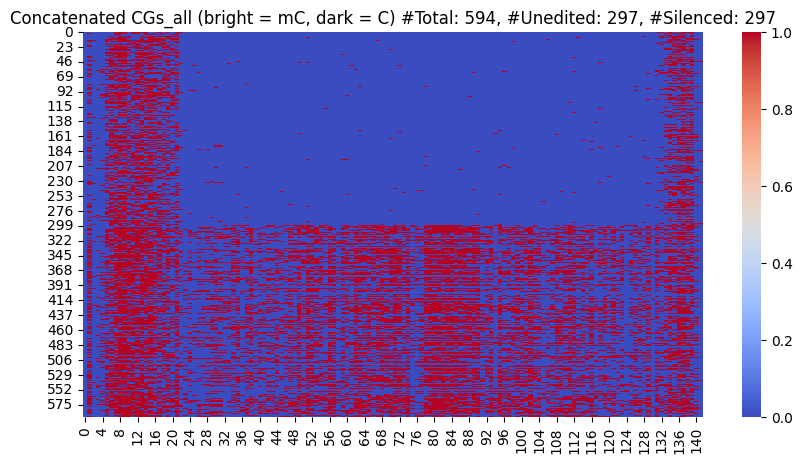

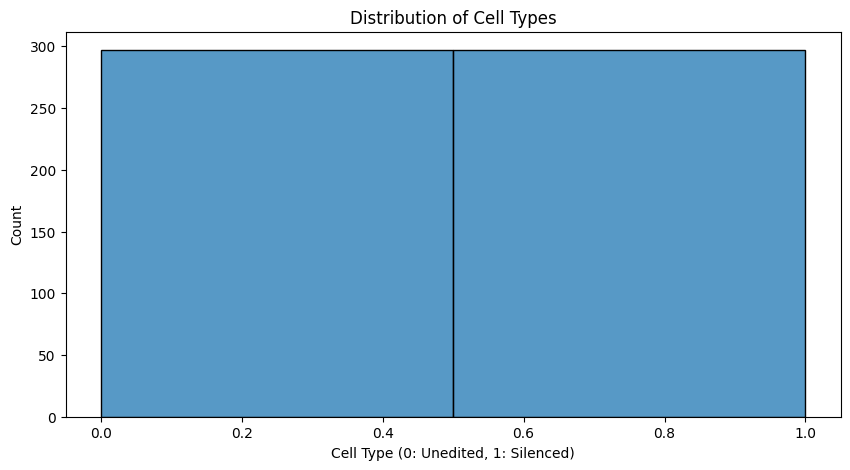

PermutationExplainer explainer: 595it [00:28, 14.42it/s]                         


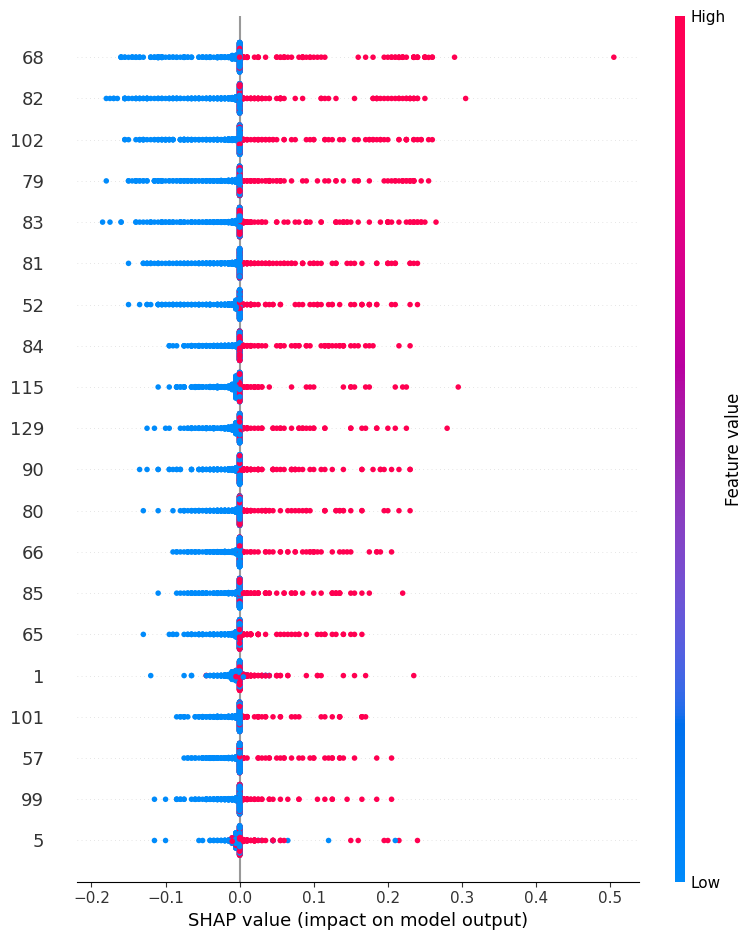

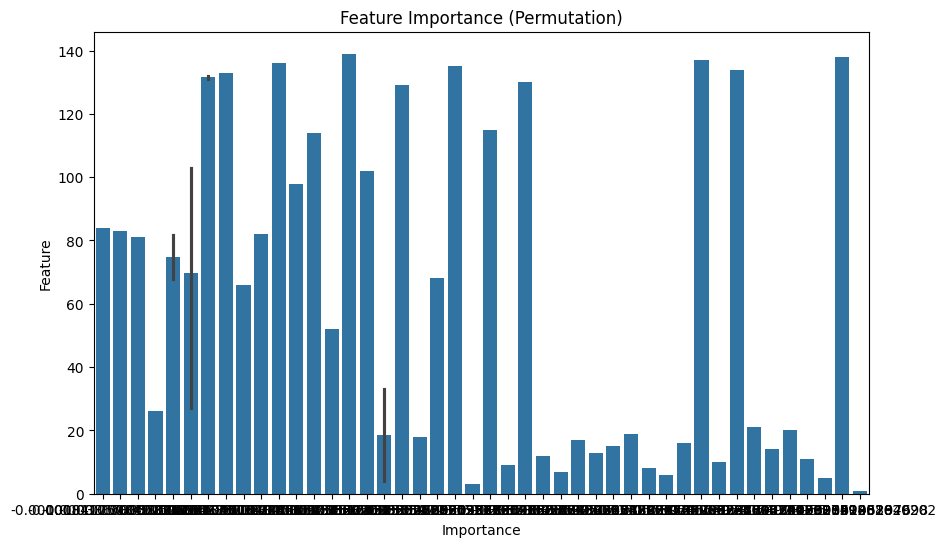

,Feature,Importance
1,1,0.020202
138,138,0.014983
5,5,0.012963
11,11,0.010101
20,20,0.009259
...,...,...
128,128,0.000000
26,26,-0.000168
81,81,-0.000337
83,83,-0.000842


In [16]:
import pandas as pd
import numpy as np
import shap
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def load_data(unedited_path, silenced_path):
    """Loads dataset from npy files, plots heatmap before balancing, balances sizes, and prepares features/labels."""
    CGs_all_unedited = np.load(unedited_path)
    CGs_all_silenced = np.load(silenced_path)
    
    # Plot heatmaps before balancing
    plot_CGs_heatmap(CGs_all_unedited, CGs_all_silenced, None)
    
    # Balance dataset size
    min_size = min(len(CGs_all_unedited), len(CGs_all_silenced))
    CGs_all_unedited = CGs_all_unedited[np.random.choice(len(CGs_all_unedited), min_size, replace=False)]
    CGs_all_silenced = CGs_all_silenced[np.random.choice(len(CGs_all_silenced), min_size, replace=False)]
    
    X = np.vstack((CGs_all_unedited, CGs_all_silenced))
    X = pd.DataFrame(X).fillna(0)
    y = np.array([0] * len(CGs_all_unedited) + [1] * len(CGs_all_silenced))
    
    return X, y, CGs_all_unedited, CGs_all_silenced

def plot_data_distribution(X, y):
    """Plots data distribution."""
    plt.figure(figsize=(10, 5))
    sns.histplot(y, bins=2, kde=False)
    plt.xlabel("Cell Type (0: Unedited, 1: Silenced)")
    plt.ylabel("Count")
    plt.title("Distribution of Cell Types")
    plt.show()

def plot_CGs_heatmap(CGs_all_unedited, CGs_all_silenced, X):
    """Plots heatmaps of CGs_all before and after balancing."""
    plt.figure(figsize=(10, 5))
    sns.heatmap(pd.DataFrame(CGs_all_unedited).fillna(-1))
    plt.title(f"CGs_all_unedited (bright = mC, dark = C)\n #Unedited: {CGs_all_unedited.shape[0]}")
    plt.show()
    plt.figure(figsize=(10, 5))
    sns.heatmap(pd.DataFrame(CGs_all_silenced).fillna(-1))
    plt.title(f"CGs_all_silenced (bright = mC, dark = C)\n #Silenced: {CGs_all_silenced.shape[0]}")
    plt.show()
    if X is not None:
        plt.figure(figsize=(10, 5))
        sns.heatmap(pd.DataFrame(X).fillna(0), cmap='coolwarm', cbar=True)
        plt.title(f"Concatenated CGs_all (bright = mC, dark = C) #Total: {X.shape[0]}, #Unedited: {CGs_all_unedited.shape[0]}, #Silenced: {CGs_all_silenced.shape[0]}")
        plt.show()

def train_models(X, y):
    """Trains multiple classification models and evaluates them."""
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(max_iter=1000)
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    results = {}
    
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
        
        results[name] = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'train_time': time.time() - start_time
        }
    
    return models, results

def feature_importance_analysis(model, X_train, y_train):
    """Computes feature importance using SHAP and Permutation Importance."""
    # SHAP analysis
    explainer = shap.Explainer(model.predict, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
    
    # Permutation Importance
    perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
    feature_importance = pd.DataFrame({'Feature': range(X_train.shape[1]), 'Importance': perm_importance.importances_mean})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
    plt.title('Feature Importance (Permutation)')
    plt.show()
    
    return feature_importance

# Example usage:
unedited_path = "/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_unedited_K562_R9P2_nCATS_2024927_numFWD240_numRVS57_padded_reads_unedited_K562_R9P2_nCATS_2024927_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy"
silenced_path = "/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_LOW_high_K562_nCATS_20241226_numFWD1576_numRVS1339_padded_reads_LOW_high_K562_nCATS_20241226_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy"
X, y, CGs_unedited, CGs_silenced = load_data(unedited_path, silenced_path)
plot_CGs_heatmap(CGs_unedited, CGs_silenced, X)
plot_data_distribution(X, y)
models, results = train_models(X, y)
feature_importance_analysis(models['Random Forest'], X, y)


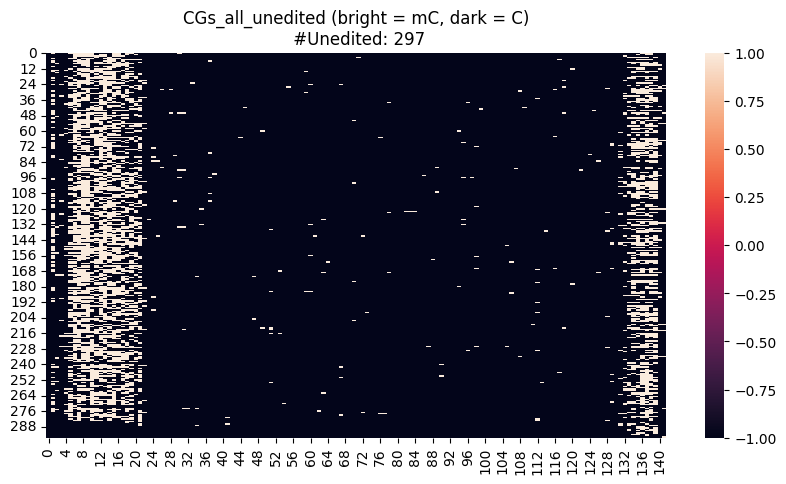

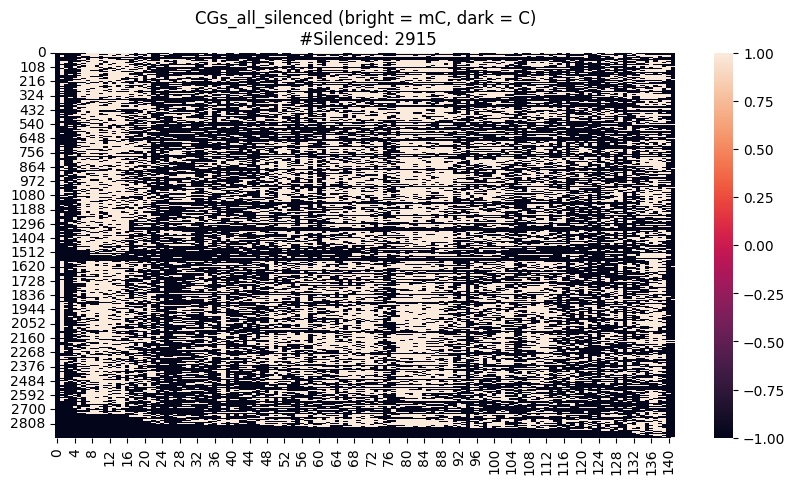

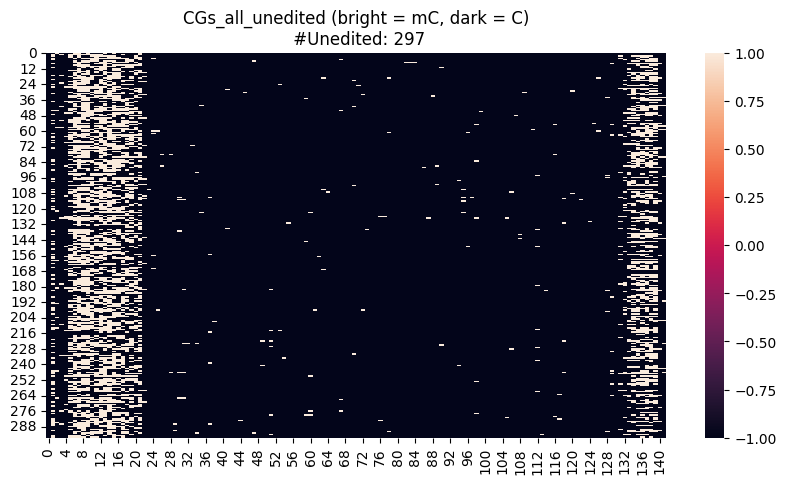

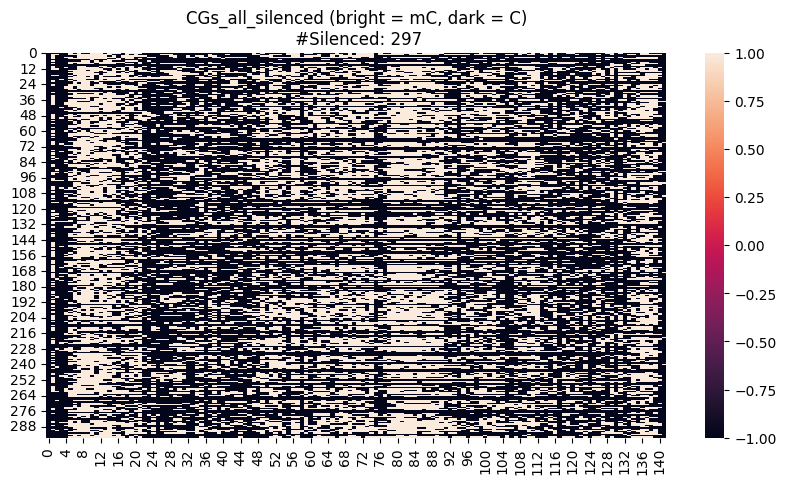

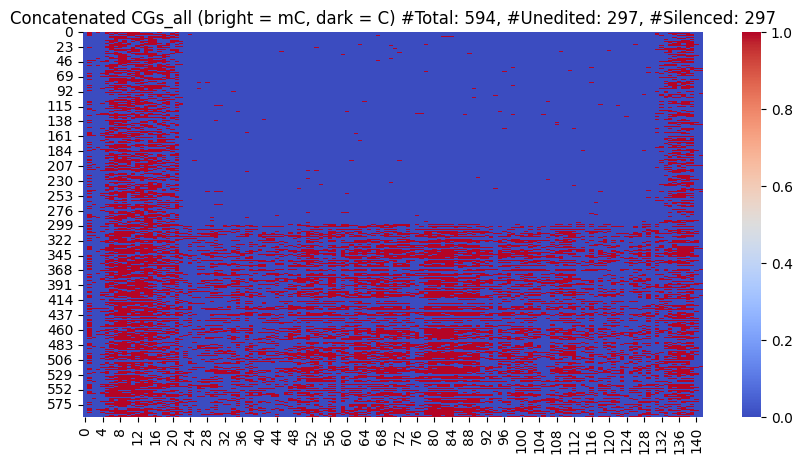

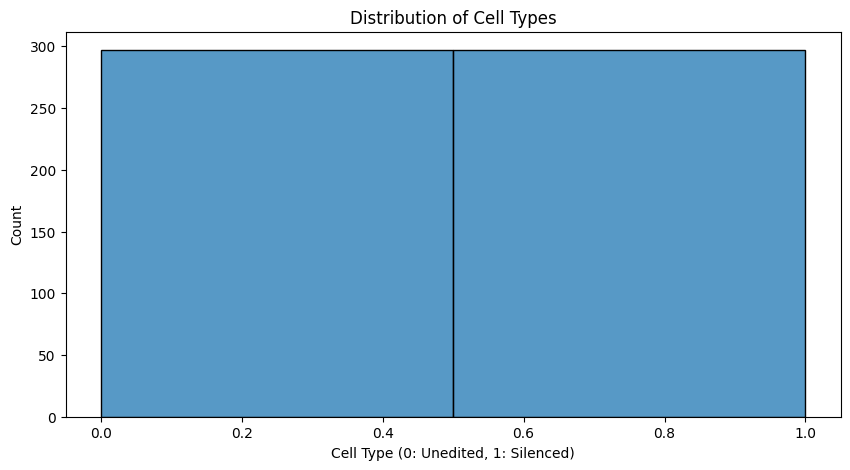

PermutationExplainer explainer: 595it [00:25, 13.19it/s]                         


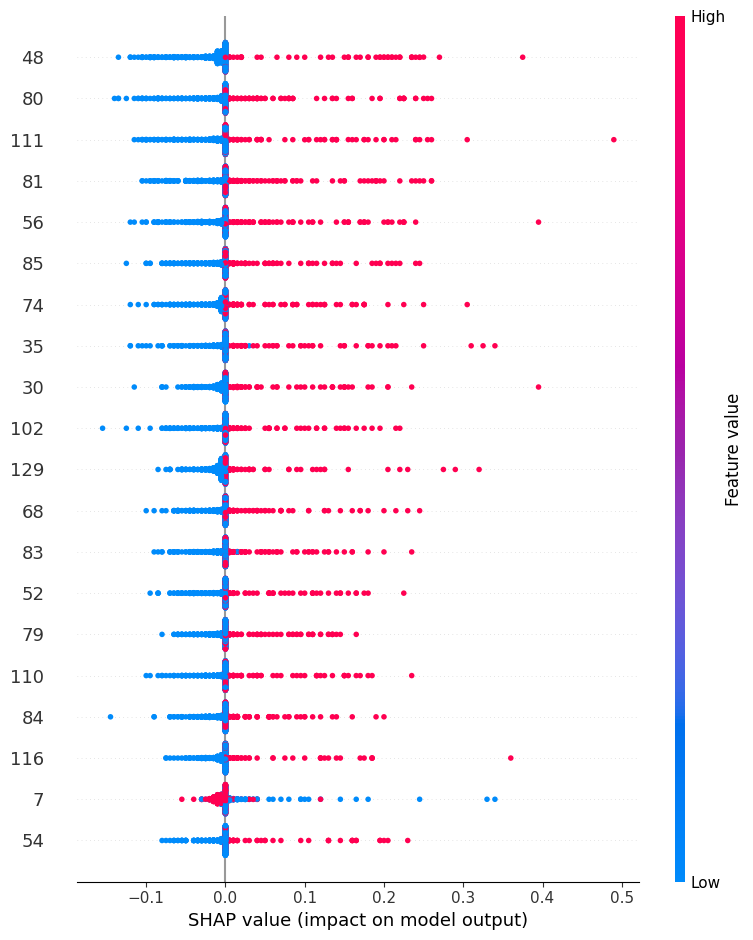

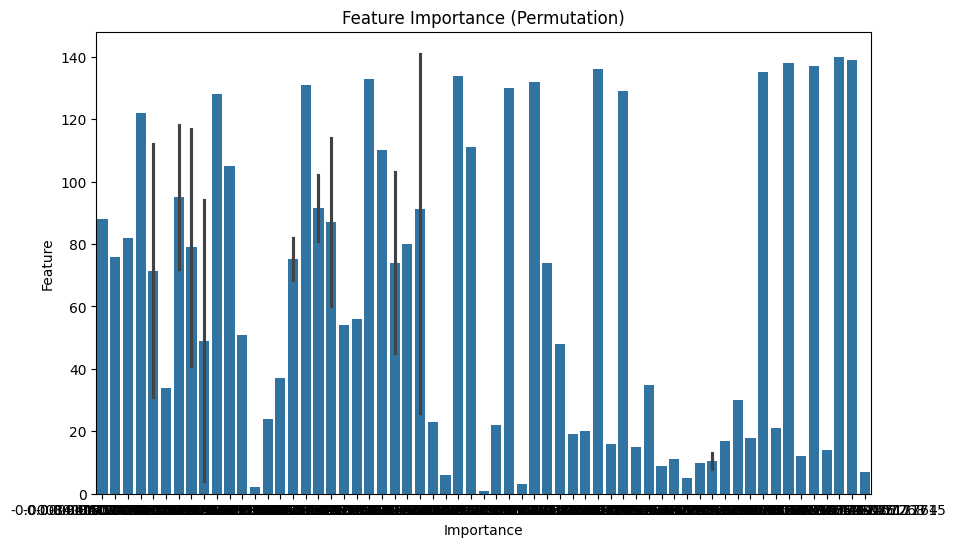

,Feature,Importance
7,7,0.017172
139,139,0.011785
140,140,0.011279
14,14,0.010774
137,137,0.010774
...,...,...
31,31,-0.000673
122,122,-0.000673
82,82,-0.000842
76,76,-0.000842


In [18]:
import pandas as pd
import numpy as np
import shap
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def load_data(unedited_path, silenced_path):
    """Loads dataset from npy files, plots heatmap before balancing, balances sizes, and prepares features/labels."""
    CGs_all_unedited = np.load(unedited_path)
    CGs_all_silenced = np.load(silenced_path)
    
    # Plot heatmaps before balancing
    plot_CGs_heatmap(CGs_all_unedited, CGs_all_silenced, None)
    
    # Balance dataset size
    min_size = min(len(CGs_all_unedited), len(CGs_all_silenced))
    CGs_all_unedited = CGs_all_unedited[np.random.choice(len(CGs_all_unedited), min_size, replace=False)]
    CGs_all_silenced = CGs_all_silenced[np.random.choice(len(CGs_all_silenced), min_size, replace=False)]
    
    X = np.vstack((CGs_all_unedited, CGs_all_silenced))
    X = pd.DataFrame(X).fillna(0)
    y = np.array([0] * len(CGs_all_unedited) + [1] * len(CGs_all_silenced))
    
    return X, y, CGs_all_unedited, CGs_all_silenced

def plot_data_distribution(X, y):
    """Plots data distribution."""
    plt.figure(figsize=(10, 5))
    sns.histplot(y, bins=2, kde=False)
    plt.xlabel("Cell Type (0: Unedited, 1: Silenced)")
    plt.ylabel("Count")
    plt.title("Distribution of Cell Types")
    plt.show()

def plot_CGs_heatmap(CGs_all_unedited, CGs_all_silenced, X):
    """Plots heatmaps of CGs_all before and after balancing."""
    plt.figure(figsize=(10, 5))
    sns.heatmap(pd.DataFrame(CGs_all_unedited).fillna(-1))
    plt.title(f"CGs_all_unedited (bright = mC, dark = C)\n #Unedited: {CGs_all_unedited.shape[0]}")
    plt.show()
    plt.figure(figsize=(10, 5))
    sns.heatmap(pd.DataFrame(CGs_all_silenced).fillna(-1))
    plt.title(f"CGs_all_silenced (bright = mC, dark = C)\n #Silenced: {CGs_all_silenced.shape[0]}")
    plt.show()
    if X is not None:
        plt.figure(figsize=(10, 5))
        sns.heatmap(pd.DataFrame(X).fillna(0), cmap='coolwarm', cbar=True)
        plt.title(f"Concatenated CGs_all (bright = mC, dark = C) #Total: {X.shape[0]}, #Unedited: {CGs_all_unedited.shape[0]}, #Silenced: {CGs_all_silenced.shape[0]}")
        plt.show()

def train_models(X, y):
    """Trains multiple classification models, evaluates them, and saves prediction scores in a table."""
    """Trains multiple classification models and evaluates them."""
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(max_iter=1000)
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    results = {}
    
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
        
        results[name] = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'train_time': time.time() - start_time
        }
    
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.to_csv("model_performance.csv", index=True)
    return models, results_df

def feature_importance_analysis(model, X_train, y_train):
    """Computes feature importance using SHAP and Permutation Importance."""
    # SHAP analysis
    explainer = shap.Explainer(model.predict, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
    
    # Permutation Importance
    perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
    feature_importance = pd.DataFrame({'Feature': range(X_train.shape[1]), 'Importance': perm_importance.importances_mean})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
    plt.title('Feature Importance (Permutation)')
    plt.show()
    
    return feature_importance

# Example usage:
unedited_path = "/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_unedited_K562_R9P2_nCATS_2024927_numFWD240_numRVS57_padded_reads_unedited_K562_R9P2_nCATS_2024927_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy"
silenced_path = "/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_LOW_high_K562_nCATS_20241226_numFWD1576_numRVS1339_padded_reads_LOW_high_K562_nCATS_20241226_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy"
X, y, CGs_unedited, CGs_silenced = load_data(unedited_path, silenced_path)
plot_CGs_heatmap(CGs_unedited, CGs_silenced, X)
plot_data_distribution(X, y)
models, results = train_models(X, y)
feature_importance_analysis(models['Random Forest'], X, y)


In [19]:
results

,accuracy,roc_auc,confusion_matrix,classification_report,train_time
Logistic Regression,0.915966,0.931882,"[[60, 1], [9, 49]]","{'0': {'precision': 0.8695652173913043, 'recal...",0.007583
Random Forest,0.924370,0.954777,"[[60, 1], [8, 50]]","{'0': {'precision': 0.8823529411764706, 'recal...",0.071200
Gradient Boosting,0.890756,0.941492,"[[59, 2], [11, 47]]","{'0': {'precision': 0.8428571428571429, 'recal...",0.110646
Decision Tree,0.831933,0.832674,"[[49, 12], [8, 50]]","{'0': {'precision': 0.8596491228070176, 'recal...",0.006212
SVM,0.915966,0.949972,"[[61, 0], [10, 48]]","{'0': {'precision': 0.8591549295774648, 'recal...",0.021535
Neural Network,0.890756,0.950537,"[[56, 5], [8, 50]]","{'0': {'precision': 0.875, 'recall': 0.9180327...",0.463644


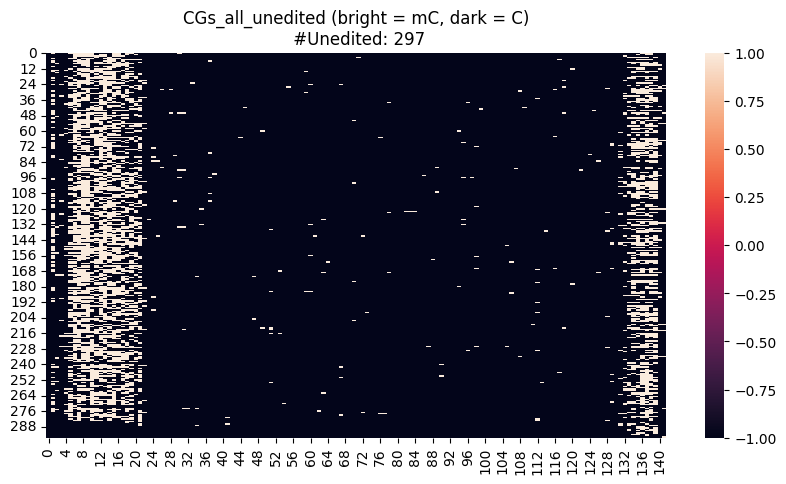

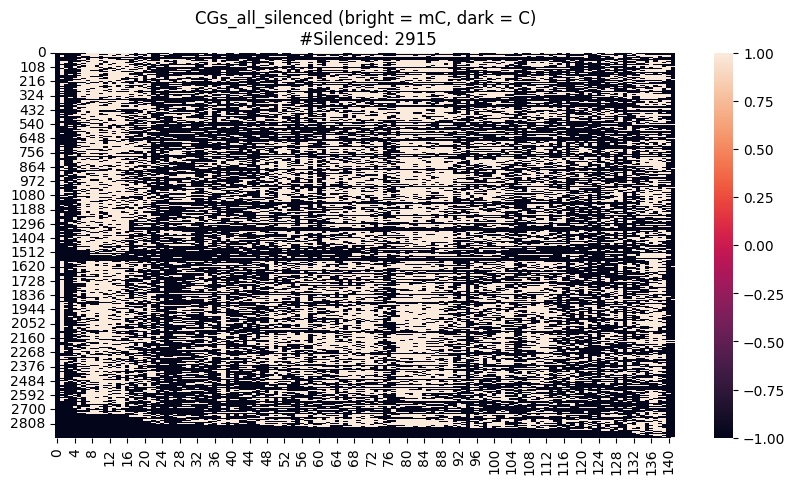

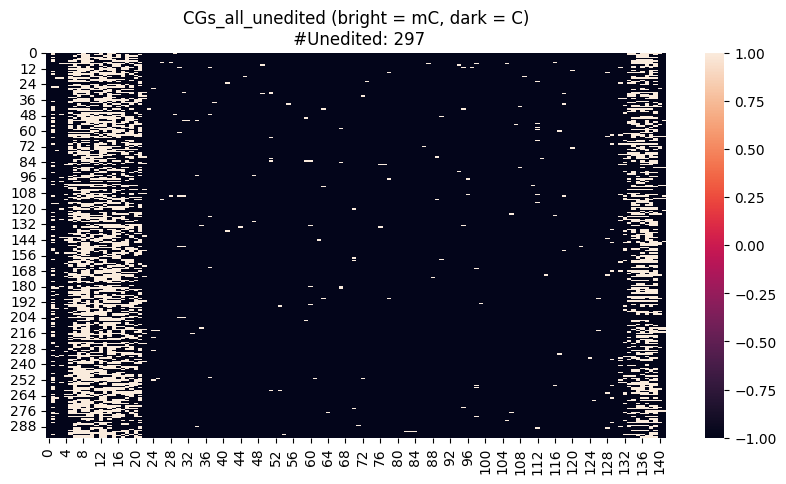

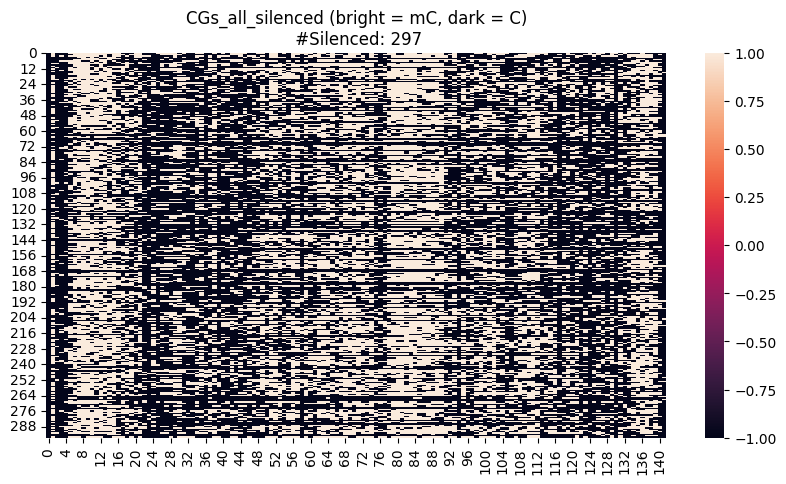

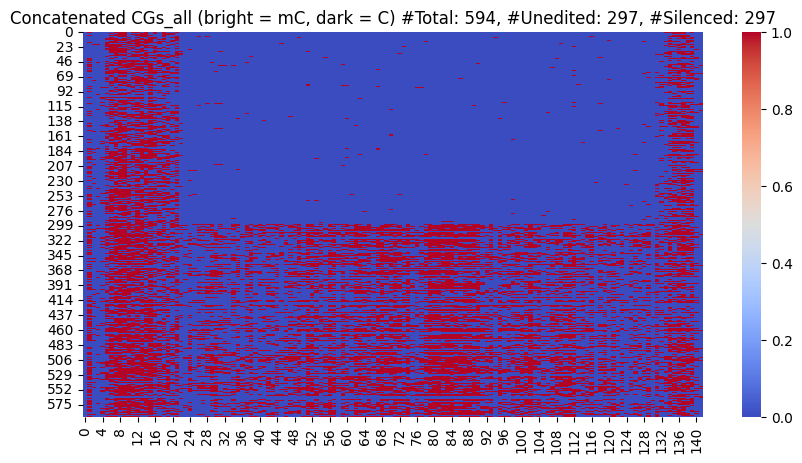

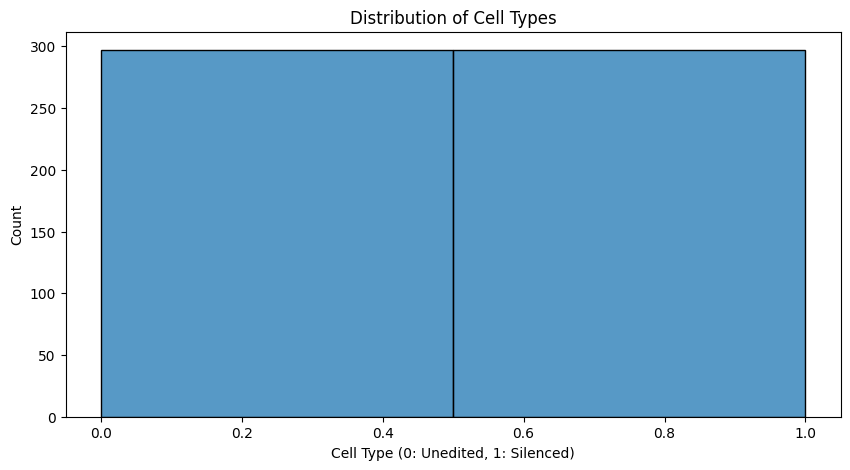

                     accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std  \
Logistic Regression       0.920852      0.013811      0.963585     0.015910   
Random Forest             0.927617      0.017272      0.966490     0.009329   
Gradient Boosting         0.914129      0.006461      0.963550     0.009857   
Decision Tree             0.875431      0.014370      0.885565     0.011698   
SVM                       0.922575      0.009685      0.967411     0.013583   
Neural Network            0.915810      0.018485      0.954973     0.014274   

                     train_time  
Logistic Regression    0.035374  
Random Forest          0.606571  
Gradient Boosting      1.062494  
Decision Tree          0.034579  
SVM                    0.145480  
Neural Network         5.616965  


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [27]:
import pandas as pd
import numpy as np
import shap
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import sklearn

def load_data(unedited_path, silenced_path):
    """Loads dataset from npy files, plots heatmap before balancing, balances sizes, and prepares features/labels."""
    CGs_all_unedited = np.load(unedited_path)
    CGs_all_silenced = np.load(silenced_path)
    
    # Plot heatmaps before balancing
    plot_CGs_heatmap(CGs_all_unedited, CGs_all_silenced, None)
    
    # Balance dataset size
    min_size = min(len(CGs_all_unedited), len(CGs_all_silenced))
    CGs_all_unedited = CGs_all_unedited[np.random.choice(len(CGs_all_unedited), min_size, replace=False)]
    CGs_all_silenced = CGs_all_silenced[np.random.choice(len(CGs_all_silenced), min_size, replace=False)]
    
    X = np.vstack((CGs_all_unedited, CGs_all_silenced))
    X = pd.DataFrame(X).fillna(0)
    y = np.array([0] * len(CGs_all_unedited) + [1] * len(CGs_all_silenced))
    
    return X, y, CGs_all_unedited, CGs_all_silenced

def plot_data_distribution(X, y):
    """Plots data distribution."""
    plt.figure(figsize=(10, 5))
    sns.histplot(y, bins=2, kde=False)
    plt.xlabel("Cell Type (0: Unedited, 1: Silenced)")
    plt.ylabel("Count")
    plt.title("Distribution of Cell Types")
    plt.show()

def plot_CGs_heatmap(CGs_all_unedited, CGs_all_silenced, X):
    """Plots heatmaps of CGs_all before and after balancing."""
    plt.figure(figsize=(10, 5))
    sns.heatmap(pd.DataFrame(CGs_all_unedited).fillna(-1))
    plt.title(f"CGs_all_unedited (bright = mC, dark = C)\n #Unedited: {CGs_all_unedited.shape[0]}")
    plt.show()
    plt.figure(figsize=(10, 5))
    sns.heatmap(pd.DataFrame(CGs_all_silenced).fillna(-1))
    plt.title(f"CGs_all_silenced (bright = mC, dark = C)\n #Silenced: {CGs_all_silenced.shape[0]}")
    plt.show()
    if X is not None:    
        plt.figure(figsize=(10, 5))
        sns.heatmap(pd.DataFrame(X).fillna(0), cmap='coolwarm', cbar=True)
        plt.title(f"Concatenated CGs_all (bright = mC, dark = C) #Total: {X.shape[0]}, #Unedited: {CGs_all_unedited.shape[0]}, #Silenced: {CGs_all_silenced.shape[0]}")
        plt.show()

def train_models(X, y, cv_folds=5, save_results_path="model_performance_cv.csv"):
    """Trains multiple classification models using cross-validation and evaluates them."""
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(max_iter=1000)
    }
    
    # Shuffle dataset
    X, y = sklearn.utils.shuffle(X, y, random_state=42)
    
    # Define Stratified K-Fold for cross-validation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    results = {}

    for name, model in models.items():
        start_time = time.time()
        
        # Cross-validation accuracy
        accuracy_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
        accuracy_mean = accuracy_scores.mean()
        accuracy_std = accuracy_scores.std()

        # Cross-validation AUC (if applicable)
        if hasattr(model, 'predict_proba'):
            roc_auc_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
            roc_auc_mean = roc_auc_scores.mean()
            roc_auc_std = roc_auc_scores.std()
        else:
            roc_auc_mean, roc_auc_std = 'N/A', 'N/A'
        
        # Store results
        results[name] = {
            'accuracy_mean': accuracy_mean,
            'accuracy_std': accuracy_std,
            'roc_auc_mean': roc_auc_mean,
            'roc_auc_std': roc_auc_std,
            'train_time': time.time() - start_time
        }

    # Save results as DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index')
    print(results_df)
    if save_results_path:
     results_df.to_csv(save_results_path, index=True)

    return models, results_df


def feature_importance_analysis(model, X_train, y_train):
    """Computes feature importance using SHAP and Permutation Importance."""
    # SHAP analysis
    explainer = shap.Explainer(model.predict, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
    
    # Permutation Importance
    perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
    feature_importance = pd.DataFrame({'Feature': range(X_train.shape[1]), 'Importance': perm_importance.importances_mean})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
    plt.title('Feature Importance (Permutation)')
    plt.show()
    
    return feature_importance

# Example usage:
unedited_path = "/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_unedited_K562_R9P2_nCATS_2024927_numFWD240_numRVS57_padded_reads_unedited_K562_R9P2_nCATS_2024927_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy"
silenced_path = "/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_LOW_high_K562_nCATS_20241226_numFWD1576_numRVS1339_padded_reads_LOW_high_K562_nCATS_20241226_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy"
X, y, CGs_unedited, CGs_silenced = load_data(unedited_path, silenced_path)
plot_CGs_heatmap(CGs_unedited, CGs_silenced, X)
plot_data_distribution(X, y)
models, results = train_models(X, y)
feature_importance_analysis(models['Random Forest'], X, y)
